In [2]:

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

print("Project root added to sys.path")


Project root added to sys.path


## Imports

In [3]:
import torch
from utils.data_loader import load_dataset
from utils.data_partition import (
    iid_partition,
    non_iid_partition,
    dirichlet_partition,
    quantity_skew_partition,
    temporal_partition,
    hybrid_partition,
)
from clients.federated_training import federated_training

c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## Configuration

In [4]:
dataset_name = "mnist"
num_clients = 5
rounds = 5
device = "cuda" if torch.cuda.is_available() else "cpu"

## Load Dataset

In [5]:
trainset, testset = load_dataset(dataset_name)

[INFO] Loaded dataset 'mnist' with 60000 training samples and 10000 testing samples.


## Create Partitions

In [11]:
partitions = {
    "iid": iid_partition(trainset, num_clients),
    "non_iid": non_iid_partition(trainset, num_clients=num_clients, num_shards=10),
    "dirichlet": dirichlet_partition(trainset, num_clients=num_clients, alpha=0.5),
    "quantity_skew": quantity_skew_partition(trainset, num_clients=num_clients),
    "temporal": temporal_partition(trainset, num_clients=num_clients),
    "hybrid": hybrid_partition(trainset, num_clients=num_clients, alpha=0.5),
}

## Visualize Partitions

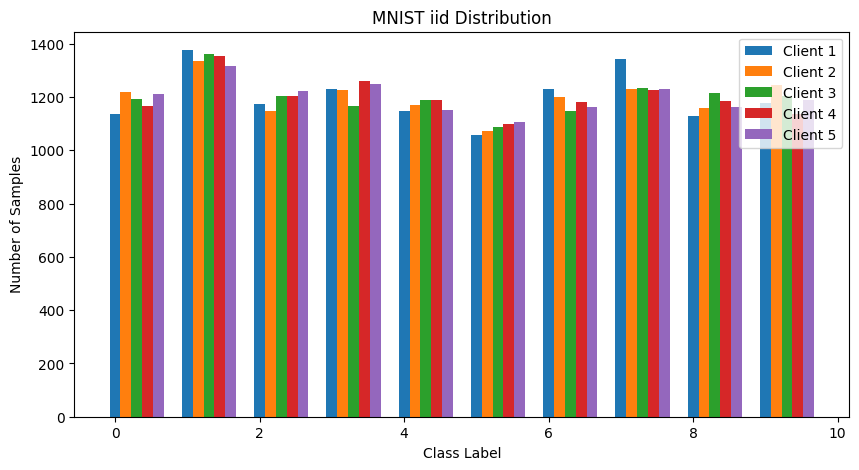

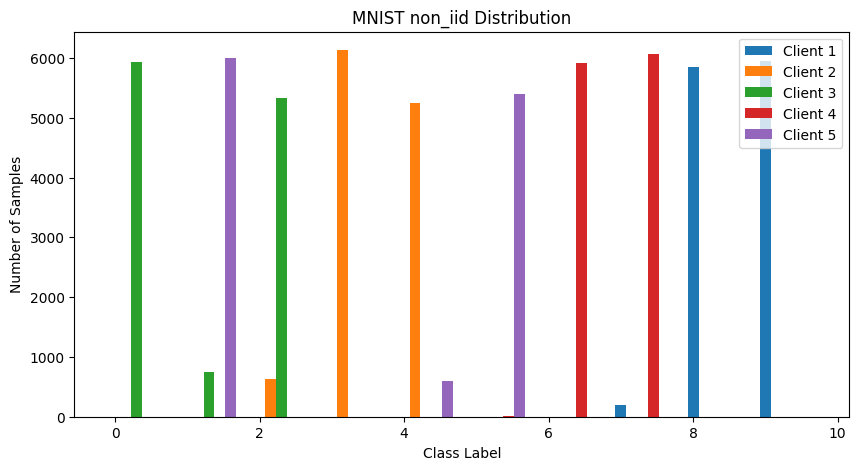

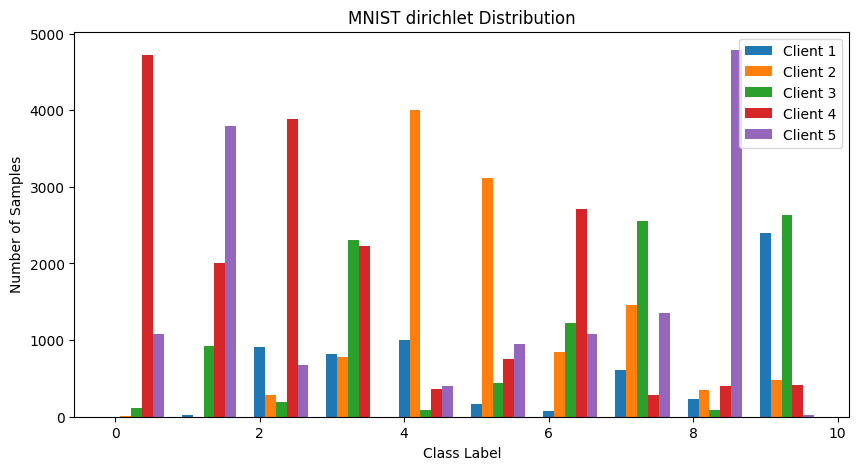

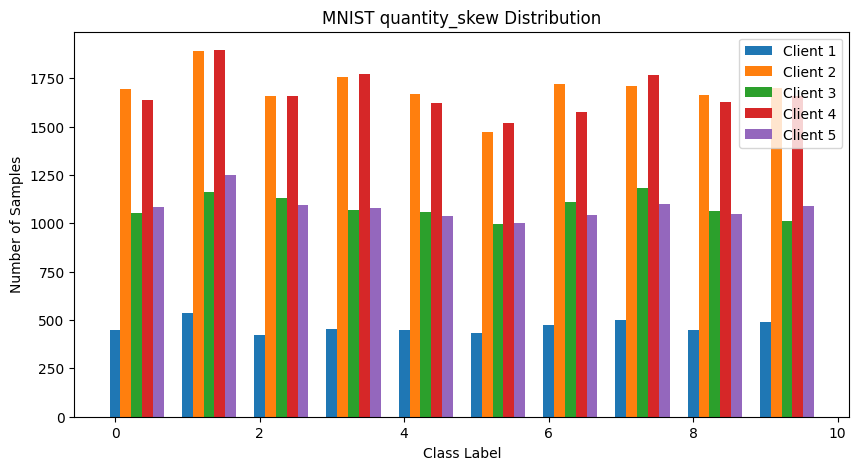

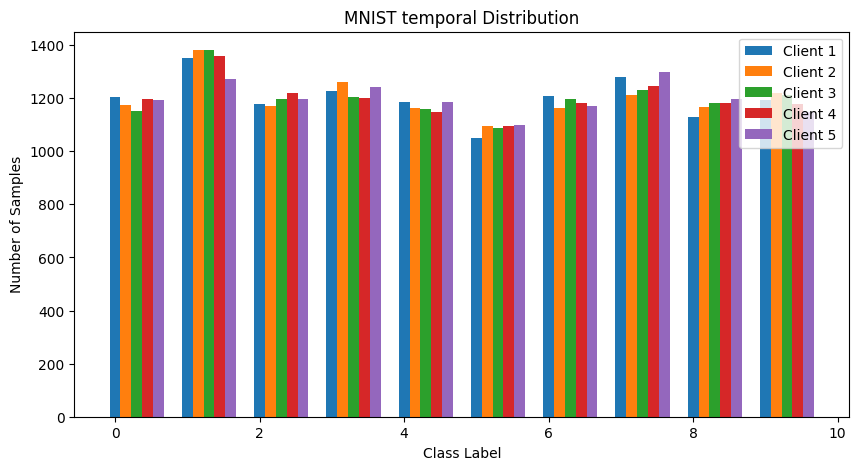

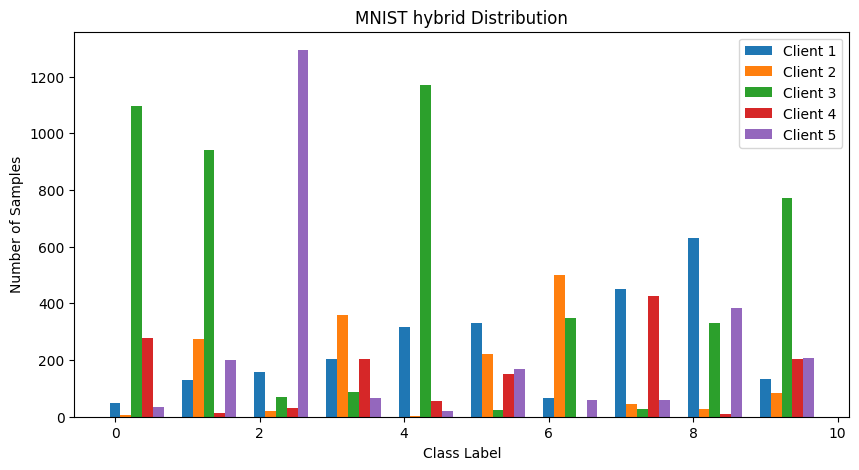

In [12]:
from utils.visualization import plot_class_distribution

for name, subsets in partitions.items():
    plot_class_distribution(subsets, trainset, f"MNIST {name} Distribution", num_classes=10)

## Federated Training Loop

In [6]:
results = {}

for strategy, subsets in partitions.items():
    print(f"\n--- Federated Training with {strategy.upper()} partitions ---")
    global_model, test_accs = federated_training(
        client_datasets=subsets,
        model_name=dataset_name,
        testset=testset,
        rounds=rounds,
        device=device
    )
    results[strategy] = test_accs


--- Federated Training with IID partitions ---

Round 1/5
Test Accuracy: 0.8893

Round 2/5
Test Accuracy: 0.9795

Round 3/5
Test Accuracy: 0.9813

Round 4/5
Test Accuracy: 0.9874

Round 5/5
Test Accuracy: 0.9890

--- Federated Training with NON_IID partitions ---

Round 1/5
Test Accuracy: 0.3281

Round 2/5
Test Accuracy: 0.7338

Round 3/5
Test Accuracy: 0.4699

Round 4/5
Test Accuracy: 0.6704

Round 5/5
Test Accuracy: 0.5988

--- Federated Training with DIRICHLET partitions ---

Round 1/5
Test Accuracy: 0.8294

Round 2/5
Test Accuracy: 0.9585

Round 3/5
Test Accuracy: 0.9769

Round 4/5
Test Accuracy: 0.9821

Round 5/5
Test Accuracy: 0.9852

--- Federated Training with QUANTITY_SKEW partitions ---

Round 1/5
Test Accuracy: 0.9234

Round 2/5
Test Accuracy: 0.9788

Round 3/5
Test Accuracy: 0.9837

Round 4/5
Test Accuracy: 0.9863

Round 5/5
Test Accuracy: 0.9889

--- Federated Training with TEMPORAL partitions ---

Round 1/5
Test Accuracy: 0.9644

Round 2/5
Test Accuracy: 0.9804

Round 3/

## Results

In [7]:
print("\nFederated Training Accuracy per Round:")
for strategy, accs in results.items():
    print(f"{strategy}: {accs}")


Federated Training Accuracy per Round:
iid: [0.8893, 0.9795, 0.9813, 0.9874, 0.989]
non_iid: [0.3281, 0.7338, 0.4699, 0.6704, 0.5988]
dirichlet: [0.8294, 0.9585, 0.9769, 0.9821, 0.9852]
quantity_skew: [0.9234, 0.9788, 0.9837, 0.9863, 0.9889]
temporal: [0.9644, 0.9804, 0.9816, 0.9861, 0.9849]
hybrid: [0.6868, 0.8938, 0.9481, 0.9683, 0.9641]


## Trying to fix non IID 
1. Weighted Aggregation (so that clients with more data or higher performance have more influence).

In [14]:
partitions = {
    "iid": iid_partition(trainset, num_clients),
    "non_iid": non_iid_partition(trainset, num_clients=num_clients, num_shards=10),
}

c:\Users\la7tim\Desktop\Internship\FedTinyProp\utils\data_partition.py:19: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  labels = np.array(dataset.targets)


In [ ]:
from clients.weighted_federated_training import weighted_federated_training

results = {}

for strategy, subsets in partitions.items():
    print(f"\n--- Federated Training with {strategy.upper()} partitions ---")
    global_model, test_accs = weighted_federated_training(
        client_datasets=subsets,
        model_name=dataset_name,
        testset=testset,
        rounds=rounds,
        device=device
    )
    results[strategy] = test_accs


--- Federated Training with IID partitions ---

Round 1/5
Test Accuracy: 0.9496

Round 2/5
Test Accuracy: 0.9751

Round 3/5
Test Accuracy: 0.9848

Round 4/5
Test Accuracy: 0.9853

Round 5/5
Test Accuracy: 0.9869

--- Federated Training with NON_IID partitions ---

Round 1/5
Test Accuracy: 0.3267

Round 2/5
Test Accuracy: 0.5505

Round 3/5
Test Accuracy: 0.3720

Round 4/5
Test Accuracy: 0.5496

Round 5/5
Test Accuracy: 0.4167


2. testing FedProx 
    - mu = 0.1

In [13]:
partitions = {
    "non_iid": non_iid_partition(trainset, num_clients=num_clients, num_shards=10),
}

In [14]:
from clients.fedProx_federated_learning import federated_training_with_fedprox

mu = 0.1  
strategy = 'non_iid'

print(f"\n--- Federated Training with FedProx on {strategy.upper()} partitions ---")
global_model, test_accs = federated_training_with_fedprox(
    client_datasets=partitions[strategy],
    model_name='mnist',  
    testset=testset,
    rounds=5,
    device="cpu",  
    mu=mu  
)



--- Federated Training with FedProx on NON_IID partitions ---

Round 1/5
Test Accuracy: 0.3564

Round 2/5
Test Accuracy: 0.1613

Round 3/5
Test Accuracy: 0.1755

Round 4/5
Test Accuracy: 0.1138

Round 5/5
Test Accuracy: 0.1033


2. testing FedProx 
    - mu = 0.001

In [15]:
from clients.fedProx_federated_learning import federated_training_with_fedprox

mu = 0.001  
strategy = 'non_iid'

print(f"\n--- Federated Training with FedProx on {strategy.upper()} partitions ---")
global_model, test_accs = federated_training_with_fedprox(
    client_datasets=partitions[strategy],
    model_name='mnist',  
    testset=testset,
    rounds=5,
    device="cpu",  
    mu=mu  
)



--- Federated Training with FedProx on NON_IID partitions ---

Round 1/5
Test Accuracy: 0.4087

Round 2/5
Test Accuracy: 0.3378

Round 3/5
Test Accuracy: 0.4264

Round 4/5
Test Accuracy: 0.6455

Round 5/5
Test Accuracy: 0.3950


2. testing FedProx 
    - increase local epochs from 1 to 3

In [16]:
from clients.fedProx_federated_learning import federated_training_with_fedprox

mu = 0.001  
strategy = 'non_iid'

print(f"\n--- Federated Training with FedProx on {strategy.upper()} partitions ---")
global_model, test_accs = federated_training_with_fedprox(
    client_datasets=partitions[strategy],
    model_name='mnist',  
    testset=testset,
    rounds=5,
    device="cpu",  
    mu=mu  
)



--- Federated Training with FedProx on NON_IID partitions ---

Round 1/5
Test Accuracy: 0.4623

Round 2/5
Test Accuracy: 0.5707

Round 3/5
Test Accuracy: 0.4848

Round 4/5
Test Accuracy: 0.6444

Round 5/5
Test Accuracy: 0.5239
